In [99]:
import torch
import numpy as np
import argparse
import imutils
import time
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

classes = ['(', ')', '+', ',', '-', 
                     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                     'A', 'F','α','and','β', 'delta', '∃', '∀',
                     'γ', 'λ', 'μ', 'not','ω','or','φ','pi','psi','→',
                     'σ','tau','θ','v','x', 'y', 'z']

NUM_CLASSES = len(classes)


def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

MODEL_PATH = 'models/mathnet/mathnet50.ml'
NUM_CLASSES 

40

In [3]:
class ResidiumBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_percentage, is_reducer=True):
        super(ResidiumBlock, self).__init__()
        self.dropout_percentage = dropout_percentage
        self.is_reducer = is_reducer
        if self.is_reducer:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1, stride=2)
        else:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act1  = torch.nn.ReLU()
        
        self.conv3 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv4 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act2  = torch.nn.ReLU()
        #self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.dropout = nn.Dropout(p=self.dropout_percentage)

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if not self.is_reducer:
            x += identity
        x = self.act1(x)
        
        identity = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        x = self.dropout(x)
        x += identity
        x = self.act2(x)
        
        return x

In [4]:
class MathNet(torch.nn.Module):
    def __init__(self, out_size=NUM_CLASSES):
        super(MathNet, self).__init__()
        self.dropout_percentage = 0.25
        
        # 28x28x1 -> 28x28x64
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        
        self.block1 = ResidiumBlock(64, 64, self.dropout_percentage, False)
        self.block2 = ResidiumBlock(64, 128, self.dropout_percentage)
        self.block3 = ResidiumBlock(128, 256, self.dropout_percentage)
        #self.block4 = ResidiumBlock(256, 512, self.dropout_percentage)

        self.pool3 = torch.nn.AvgPool2d(kernel_size=7, stride=7, padding=0)
        self.dropout3 = nn.Dropout(p=self.dropout_percentage)
        
        self.fc1 = torch.nn.Linear(256, NUM_CLASSES)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        #x = self.block4(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)  
        return x

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=12, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=3, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, NUM_CLASSES)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [6]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [7]:
class ResNet(torch.nn.Module):
    def __init__(self, block, image_channels, num_classes):
        super(ResNet, self).__init__()
        layers = [2, 2, 2, 2]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, 
                                                      intermediate_channels, 
                                                      kernel_size=1, 
                                                      stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [8]:
def ResNet18(img_channels=3, num_classes=NUM_CLASSES):
    return ResNet(Block, img_channels, num_classes)

In [9]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
(H, W) = (400, 400)
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, kwargs):
        self.model = MathNet()
        self.model.load_state_dict(torch.load(pretrained_classifier_path))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.kwargs = kwargs
    
    def tttt(self, image, step, ws):
        potential = []
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                crop_img = image[y:y+28, x:x+28]
                #print(type(image), type(crop_img))
                crop_tensor = transforms.ToTensor()
                
               
                
                thresh = 120
                ret,thresh_img = cv2.threshold(crop_img, thresh, 255, cv2.THRESH_BINARY)

                #find contours
                contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                img_contours = np.uint8(np.zeros((crop_img.shape[0],crop_img.shape[1])))
                cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
                
                if (len(contours) > 1):
                    #print(x,y, len(contours))
                    #img = Image.fromarray(crop_img.astype('uint8'))
                    #img = Image.fromarray(img_contours.astype('uint8'))
                    #display(img)
                    potential.append(crop_img)
        return potential
    
    def predict(self, lst):
        res = []
        for image in lst:
            img = Image.fromarray(image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(1),
                transforms.ToTensor()

            ])

            
            x_image = convert_tensor(img)
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            preds = self.model(x_image) 
            prob = preds.max()
            if prob >= self.kwargs['MIN_CONF']:
                print(prob.item(), (map_pred(preds.argmax()), preds))
                img = Image.fromarray(image.astype('uint8'))
                display(img)
            
                res.append((map_pred(preds.argmax()), preds))

        
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')

    
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.predict(rois)
        #preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        res = []
        for i in range(0, len(preds)):
            res.append((map_pred(preds[i].argmax()), preds[i].max()))
        #print(res)
        labels = {}

        for (i, p) in enumerate(res):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, endX, endY) in boxes:
                cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
            ax.imshow(clone, cmap='gray')
    
    def __call__(self, img):
        potential = self.tttt(img, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE'])
        self.predict(potential)
        
        rois, locs = self.get_rois_and_locs()
        print(6666666666666)
#         if self.kwargs['VIZ_ROIS']:
#             self.visualize_rois(rois)
        
        preds, labels = self.get_preds(rois, locs)
        print(777777777777)
        nms_labels = self.apply_nms(labels)
        print(888888888888)
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        print(999999999999)
        return nms_labels



In [11]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=3,
    ROI_SIZE=(21, 21),
    INPUT_SIZE=(28, 28),
    VISUALIZE=True,
    MIN_CONF=0.2,
    VIZ_ROIS=False
)

In [12]:
IMAGE_NAME = '5.jpg'
image = cv2.imread(IMAGE_NAME)
# cv2.imshow('contours', image)
# cv2.waitKey()
# cv2.destroyAllWindows()
#image = resize_image(image, 256)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [13]:
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
1

1

In [14]:
sw = SlidingWindowObjectDetection(MODEL_PATH, kwargs)
IMAGE_NAME = '5.jpg'
image = cv2.imread(IMAGE_NAME)
img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#sw(img_grey)
print('END')


END


In [15]:
def resize_image(image, dst):
#     # соотношение сторон: ширина, делённая на ширину оригинала
#     ratio = float(dwt / image.shape[1])
#     print(ratio)
#     # желаемая высота: высота, умноженная на соотношение сторон
#     dht = int(image.shape[0] * ratio)
#     print(image.shape[0] * ratio)
#     dim = (dwt, dht)  # итоговые размеры
#     print(dim)
    # Масштабируем картинку
    # Подготовим новые размеры
    x = float(dst) / image.shape[1]
    y = float(dst) / image.shape[0]
    # уменьшаем изображение до подготовленных размеров
    return cv2.resize(image, (0,0), fx=x,fy=y, interpolation = cv2.INTER_AREA)

In [16]:
def resize_letter(image, dst):
    return None

In [17]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width

In [79]:
def letters_extract(image_file, out_size=224):
    img = cv2.imread(image_file)
    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=3)
#     cv2.imshow('MyPhoto', img_erode)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
#     cv2.imshow('MyPhoto', img_contours )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 100 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
#     cv2.imshow('result', result )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
#     cv2.imshow('MyPhoto', img_contours )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        
        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    return letters, output

In [80]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [143]:
def img_to_str(model, image_file):
    letters, output = letters_extract(image_file)   
    output = Image.fromarray(output.astype('uint8'))
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    s_out = ""
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    print()
    for i in range(len(letters)):
        img = Image.fromarray(letters[i].image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(1),
            transforms.ToTensor()

        ])        
        x_image = convert_tensor(img)
        aaa = transforms.ToPILImage()
        display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        pred_arg_max = pred.argmax().item()
        mapped = map_pred(pred_arg_max)
        
        #cv2.putText(output, mapped+' '+"{:.2f}".format(pred.max().item()), (letters[i].x, letters[i].y), cv2.FONT_HERSHEY_COMPLEX, 0.45, (0, 0, 0), 1)

        # Draw non-ascii text onto image
        font = ImageFont.truetype("ARIALUNI.TTF", 24, encoding="unic")
        draw = ImageDraw.Draw(output)
        draw.text((letters[i].x, letters[i].y), mapped+' '+"{:.2f}".format(pred.max().item()), font=font)
        
        x = letters[i].x
        y = letters[i].y
        size = (letters[i].width, letters[i].height)
        if (letters[i].line >  prev_line):
            s_out += "\n"
            prev_line = letters[i].line
        prev_loc, prev_size = (x,y), size
        s_out += mapped + ' '
        print(letters[i].image.shape, "{:.2f}".format(pred.max().item()), mapped)
    #output = Image.fromarray(output.astype('uint8'))
    display(output)
    return s_out

In [144]:
model = MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


SHAPE:  (18,)
(72.44444444444444, 85.66666666666667)



(97, 97) 5.70 1


(54, 54) 5.28 -


(106, 106) 5.63 α


(66, 66) -0.89 or


(114, 114) 12.37 A


(60, 60) -0.37 +


(95, 95) 8.46 3


(76, 76) -0.68 v


(134, 134) 6.59 φ


(91, 91) 8.97 4


(52, 52) -1.94 8


(97, 97) 17.55 5


(113, 113) 13.94 F


(71, 71) 5.85 -


(107, 107) 8.34 ∃


(79, 79) 0.55 γ


(106, 106) 12.53 ∀


(115, 115) 0.10 φ


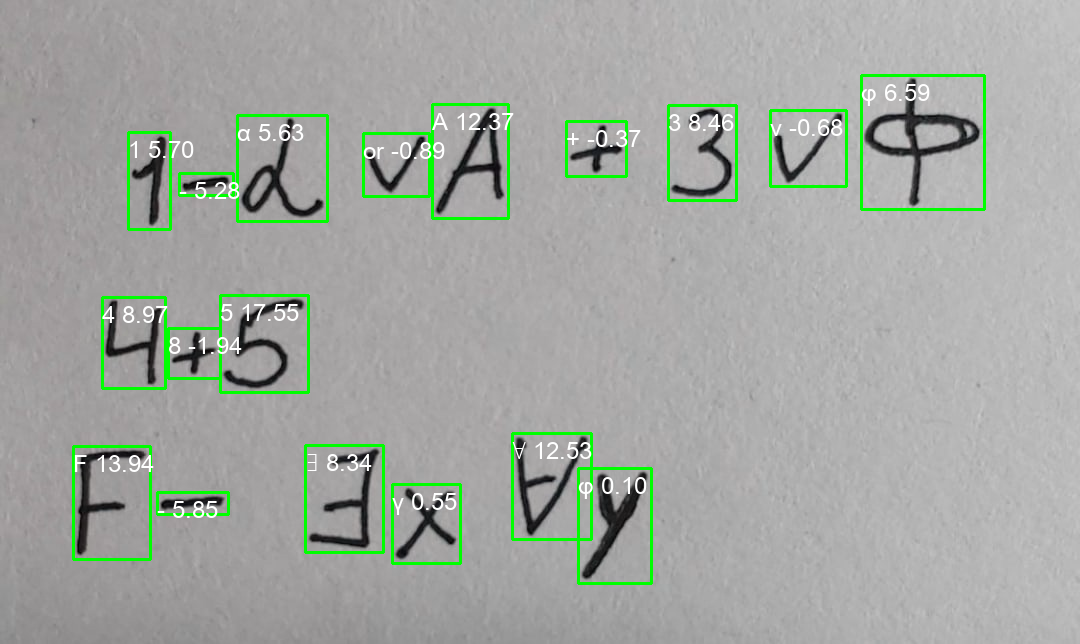

RESULT:
1 - α or A + 3 v φ 
4 8 5 
F - ∃ γ ∀ φ 


In [145]:
s = img_to_str(model, 'real2.jpg')
print('RESULT:')
print(s)

In [109]:
def abracadabra():
    img = cv2.imread('real.jpg')
    cv2.imshow('MyPhoto', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.imshow('contours', resize_image(thresh_img, 224))
    #     cv2.waitKey()
    #     cv2.destroyAllWindows()

    output = img.copy()

    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('origin', resize_image(img, 224)) # выводим итоговое изображение в окно
    #cv2.imshow('gray', resize_image(gray, 224)) # выводим итоговое изображение в окно
    cv2.imshow('res', resize_image(img_contours, 224)) # выводим итоговое изображение в окно

    cv2.waitKey()
    cv2.destroyAllWindows()


In [25]:
model = MathNet()
model.load_state_dict(torch.load('models//mathnet/mathnet40.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

tensor([[ -35.7560,  -83.4074,    9.6378,  -30.1641,  138.8463,  -87.9672,
          -35.9806,  -15.7978, -121.9077,  -25.7083,  -72.7010,  -40.5788,
          -80.8809, -124.5996,  -65.4014,  -97.9325,  -82.7984,  -40.5088,
          -81.7447,  -78.5655,  -97.4023, -114.0717, -102.8791, -108.1404,
         -123.3939,  -89.8792,  -91.1204,  -86.8871, -123.7074,  -74.8309,
         -114.4659, -125.8059,  -46.3746,  -77.5773,  -76.7865,  -67.2010,
         -120.3713,  -61.5120, -105.3705,  -64.8263]], device='cuda:0',
       grad_fn=<MulBackward0>) -
